In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

from torch.nn.utils.rnn import pad_sequence
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import logging
import os

In [2]:
import nltk
import spacy

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
logs_dir = "logs"
base_path = r"U:\nlp_project\Personalized-Medicine-Redefining-Cancer-Treatment\artifacts"
logs_dir = os.path.join(base_path,logs_dir)

In [5]:
def return_logger(file_name,idx):
    if not os.path.exists(logs_dir):
        os.makedirs(logs_dir, exist_ok=True)
        
    log_file_path = os.path.join(logs_dir, f"training_{file_name}_log_file_{idx}.log")

    logger = logging.getLogger()

    logging.basicConfig(filename=log_file_path, format='%(asctime)s %(message)s', filemode='w')
    
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    return logger

In [6]:
final_data = pd.read_csv(r"U:\nlp_project\Personalized-Medicine-Redefining-Cancer-Treatment\artifacts\data\final_data.csv")

In [7]:
final_data["Gene"].nunique()

263

In [8]:
final_data["Variation"].nunique()

2993

In [9]:
final_data.shape

(3315, 5)

In [10]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3315 entries, 0 to 3314
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         3315 non-null   int64  
 1   Gene       3315 non-null   object 
 2   Variation  3315 non-null   object 
 3   Text       3315 non-null   object 
 4   Class      3315 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 129.6+ KB


In [11]:
y_true = final_data['Class']

In [12]:
final_data.Gene = final_data.Gene.str.replace('\s+', '_')
final_data.Variation = final_data.Gene.str.replace('\s+', '_')

X_train, X_test, y_train, y_test = train_test_split(final_data, y_true, random_state=42, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=45, test_size=0.20)

In [13]:
print(f"X_train shape:{X_train.shape} y_train shape{y_train.shape}")
print(f"X_test shape:{X_test.shape} y_train shape{y_test.shape}")
print(f"X_test shape:{X_val.shape} y_train shape{y_val.shape}")

X_train shape:(2121, 5) y_train shape(2121,)
X_test shape:(663, 5) y_train shape(663,)
X_test shape:(531, 5) y_train shape(531,)


In [14]:
torch.cuda.memory_allocated()
torch.cuda.max_memory_allocated()

0

#### Prepairing Data:

In [ ]:
train_text = X_train["Text"].tolist()
test_text = X_test["Text"].tolist() 
validation_text = X_val["Text"].tolist()

def get_tokenized_text(texts):
    tokenized_text = []
    for text in texts:
        tokenized_text.append(nlp(text))  # Assuming nlp is a spaCy tokenizer
    return tokenized_text

def create_vocabulary(tokenized_text):
    unique_word = set(str(word) for sublist in tokenized_text for word in sublist)  # Convert tokens to strings
    vocab = {word: index for index, word in enumerate(unique_word, start=2)}
    vocab["<pad>"] = 0  # Padding token
    vocab["<unk>"] = 1  # Unknown token
    return vocab

def text_to_numerical_representation(vocab, tokenized_text):
    normalized_data = [[vocab.get(str(word), vocab["<unk>"]) for word in sentence] for sentence in tokenized_text]
    return normalized_data

tokenized_text_train = get_tokenized_text(train_text)
tokenized_text_test = get_tokenized_text(test_text)
tokenized_text_validation = get_tokenized_text(validation_text)

vocab = create_vocabulary(tokenized_text_train)

In [ ]:
text_to_numerical_representation_train = text_to_numerical_representation(vocab, tokenized_text_train)
text_to_numerical_representation_test = text_to_numerical_representation(vocab, tokenized_text_test)
text_to_numerical_representation_val = text_to_numerical_representation(vocab, tokenized_text_validation)

In [ ]:
text_to_numerical_representation_train = [torch.tensor(txt) for txt in text_to_numerical_representation_train]
text_to_numerical_representation_test = [torch.tensor(txt) for txt in text_to_numerical_representation_test]
text_to_numerical_representation_val = [torch.tensor(txt) for txt in text_to_numerical_representation_val]

In [ ]:
print(torch.cuda.memory_allocated())
print(torch.cuda.max_memory_allocated())

In [16]:
import gc
# del train_data, test_data, val_data  # Delete variables if they exist
gc.collect()  # Python garbage collection
torch.cuda.empty_cache()

In [15]:
def encode_cat(categories, encoder):
    print("encoding")
    return torch.tensor([encoder.transform([cat])[0] if cat in encoder.classes_ else -1 for cat in categories])

In [ ]:
gene_train = X_train["Gene"].tolist()
variation_train = X_train["Variation"].tolist()

gene_test = X_test["Gene"].tolist()
variation_test = X_test["Variation"].tolist()

gene_val = X_val["Gene"].tolist()
variation_val = X_val["Variation"].tolist()

In [ ]:
encoder_gene = LabelEncoder()
encoder_variation = LabelEncoder()

In [ ]:
gene_train_encoded = encoder_gene.fit_transform(gene_train)
variation_train_encoded = encoder_variation.fit_transform(variation_train)

In [ ]:
gene_test_encoded = encode_cat(gene_test,encoder_gene)
variation_test_encoded = encode_cat(variation_test,encoder_variation)

In [ ]:
gene_val_encoded = encode_cat(gene_val,encoder_gene)
variation_val_encoded = encode_cat(variation_val,encoder_variation)

In [ ]:
# text_to_numerical_representation_train = pad_sequence(sequences=text_to_numerical_representation_train,batch_first=True,padding_value=True)
# text_to_numerical_representation_test = pad_sequence(sequences=text_to_numerical_representation_test,batch_first=True,padding_value=True)
# text_to_numerical_representation_val = pad_sequence(sequences=text_to_numerical_representation_val,batch_first=True,padding_value=True)

In [16]:
import gc
# del train_data, test_data, val_data  # Delete variables if they exist
gc.collect()  # Python garbage collection
torch.cuda.empty_cache()

print(torch.cuda.memory_allocated())
print(torch.cuda.max_memory_allocated())

0
0


#### Saving Prepaired data:

In [ ]:
import numpy as np

np.savez("train_datas.npz", 
         padded_text=np.array(text_to_numerical_representation_train,dtype=object), 
         encoded_gene=np.array(gene_train_encoded), 
         encoded_variance=np.array(variation_train_encoded) ,allow_pickle=True)

np.savez("test_datas.npz", 
         padded_text=np.array(text_to_numerical_representation_test,dtype=object), 
         encoded_gene=np.array(gene_test_encoded), 
         encoded_variance=np.array(variation_test_encoded),allow_pickle=True)

np.savez("val_datas.npz", 
         padded_text=np.array(text_to_numerical_representation_val,dtype=object), 
         encoded_gene=np.array(gene_val_encoded), 
         encoded_variance=np.array(variation_val_encoded),allow_pickle=True)

print("Data saved successfully!")

In [ ]:
np.savez("target.npz", 
         y_train=np.array(y_train), 
         y_test=np.array(y_test), 
         y_val=np.array(y_val),allow_pickle=True)

In [ ]:
import pickle

# Save to a file
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

#### loading prepaired data:

In [16]:
train_data = np.load(r"U:\nlp_project\Personalized-Medicine-Redefining-Cancer-Treatment\artifacts\data\deep_learning_data\train_datas.npz",allow_pickle=True)
test_data = np.load(r"U:\nlp_project\Personalized-Medicine-Redefining-Cancer-Treatment\artifacts\data\deep_learning_data\test_datas.npz",allow_pickle=True)
val_data = np.load(r"U:\nlp_project\Personalized-Medicine-Redefining-Cancer-Treatment\artifacts\data\deep_learning_data\val_datas.npz",allow_pickle=True)


text_to_numerical_representation_train = train_data["padded_text"].tolist()
gene_train_encoded = train_data["encoded_gene"].tolist()
variation_train_encoded = train_data["encoded_variance"].tolist()

text_to_numerical_representation_test = test_data["padded_text"].tolist()
gene_test_encoded = test_data["encoded_gene"].tolist()
variation_test_encoded = test_data["encoded_variance"].tolist()

text_to_numerical_representation_val = val_data["padded_text"].tolist()
gene_val_encoded = val_data["encoded_gene"].tolist()
variation_val_encoded = val_data["encoded_variance"].tolist()

print("Data loaded successfully!")

Data loaded successfully!


In [17]:
print(min(gene_val_encoded))
print(max(gene_val_encoded))

-1
225


In [18]:
print(min(gene_test_encoded))
print(max(gene_test_encoded))

-1
221


In [19]:
import pickle
# Load the dictionary
with open(r"U:\nlp_project\Personalized-Medicine-Redefining-Cancer-Treatment\artifacts\data\deep_learning_data\vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

In [20]:
target_data = np.load(r"U:\nlp_project\Personalized-Medicine-Redefining-Cancer-Treatment\artifacts\data\deep_learning_data\target.npz", allow_pickle=True)


y_train = target_data["y_train"].tolist()
y_test = target_data["y_test"].tolist()
y_val = target_data["y_val"].tolist()

In [21]:
encoder_target = LabelEncoder()
y_train = encoder_target.fit_transform(y_train)

y_test = encode_cat(y_test, encoder_target)
y_val = encode_cat(y_val,encoder_target)

encoding
encoding


#### Model Creation:

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [23]:
# Example Parameters
vocab_size = len(vocab.keys())
embed_dim = int(vocab_size ** 0.25)
hidden_dim = 128
num_classes = 9
gene_size = 263
variance_size = 2993
gene_emb_dim = 5
variance_emb_dim = 5

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

class MultiClassLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, gene_size, variance_size, gene_emb_dim, variance_emb_dim):
        super(MultiClassLSTM, self).__init__()

        # Text feature embedding + LSTM
        self.text_embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)

        # Categorical feature embeddings
        self.gene_embedding = nn.Embedding(gene_size, gene_emb_dim)
        self.variance_embedding = nn.Embedding(variance_size, variance_emb_dim)
        # Fully connected layer for classification
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + gene_emb_dim + variance_emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, text_input, gene_input, variance_input):
        # Process text input through embedding and LSTM
        text_embedded = self.text_embedding(text_input)
        lstm_out, _ = self.lstm(text_embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the last hidden state

        # Process categorical inputs through embeddings
        gene_embedded = self.gene_embedding(gene_input).squeeze(1)
        variance_embedded = self.variance_embedding(variance_input).squeeze(1)

        # Concatenate all features
        combined = torch.cat((lstm_out, gene_embedded, variance_embedded), dim=1)

        # Classification output
        output = self.fc(combined)
        return output


# Model Initialization
model = MultiClassLSTM(vocab_size, embed_dim, hidden_dim, num_classes, gene_size, variance_size, gene_emb_dim, variance_emb_dim)


y_full_np = np.concatenate([y_train, y_test, y_val])  # Full dataset labels
unique_classes = np.unique(y_full_np)[1:]
# unique_classes = np.array([0,1,2,3,4,5,6,7,8])
# print(unique_classes)
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0,1,2,3,4,5,6,7,8]), y=y_full_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

# Define loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.1)

optimizer.zero_grad()

#### DataLoader:

In [25]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomDataset(Dataset):

    def __init__(self, text, gene, variance, classes):
        self.text = text
        self.gene = gene
        self.variance = variance
        self.classes = classes
        self.max_size = 500

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        return self.text[idx], self.gene[idx], self.variance[idx], self.classes[idx]


def collate_fn(batch):
    text_list = []
    variation_list = []
    gene_list = []
    label_list = []
    for text_data, gene_data, variation_data, classes in batch:
        if len(text_data) > 500:
            text_data = text_data[:2500]
        text_list.append(text_data)
        gene_list.append(gene_data)
        variation_list.append(variation_data)
        label_list.append(classes)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)

    return text_list, torch.tensor(gene_list), torch.tensor(variation_list), torch.tensor(label_list)


train_dataset = CustomDataset(text_to_numerical_representation_train, gene_train_encoded, variation_train_encoded, y_train)
test_dataset = CustomDataset(text_to_numerical_representation_test, gene_test_encoded, variation_test_encoded, y_test)
val_dataset = CustomDataset(text_to_numerical_representation_val, gene_val_encoded, variation_val_encoded, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True, num_workers=0, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, drop_last=True, num_workers=0, collate_fn=collate_fn)
validation_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, drop_last=True, num_workers=0, collate_fn=collate_fn)


In [26]:
torch.cuda.empty_cache()

In [27]:
import gc 
gc.collect()

47

In [28]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [29]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [30]:
num_epochs = 10
train_losses = []
val_losses = []
os.environ["TORCH_USE_CUDA_DSA"] = "1"
import os

torch.cuda.set_per_process_memory_fraction(0.5, device='cuda:0')  # 50% of GPU memory


model.to(device)
for epoch in range(num_epochs):
    logger = return_logger("training_lstm1",epoch+1)
    torch.cuda.empty_cache()
    logger.info(f"----------------------------FOR EPOCH-{epoch}----------------------------")
    model.train()  # Set model to training mode
    total_train_loss = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        text_input, gene_input, variance_input, labels = batch

        # Move to device (if using GPU)
        text_input = text_input.to(device)
        gene_input = gene_input.to(device)
        variance_input = variance_input.to(device)
        labels = labels.to(device)  # Labels should be integer class indices

        # print(text_input.device, gene_input.device, variance_input.device, labels.device)

        optimizer.zero_grad()  # Clear previous gradients
        
        outputs = model(text_input.long(), gene_input.long(), variance_input.long())

        # Compute Log Loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Compute average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # ================== Validation Phase ==================
    model.eval()  # Set model to evaluation mode
    total_val_loss = []

    

    with torch.no_grad():  # No gradient calculation during validation
        for batch in tqdm(validation_dataloader):
            text_input, gene_input, variance_input, labels = batch
            if (-1 not in gene_input) or (-1 not in variance_input):
                text_input = text_input.to(device)
                gene_input = gene_input.to(device)
                variance_input = variance_input.to(device)
                labels = labels.to(device)

                outputs = model(text_input.long(), gene_input.long(), variance_input.long())
                loss = criterion(outputs, labels)       
                total_val_loss.append(loss.item())
                gc.collect()
                torch.cuda.empty_cache()

        avg_val_loss = sum(total_val_loss) / len(validation_dataloader)
        val_losses.append(avg_val_loss)
            
        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Store losses for future use
torch.save({'train_loss': train_losses, 'val_loss': val_losses}, 'losses.pth')

100%|██████████| 66/66 [00:06<00:00, 10.84it/s]


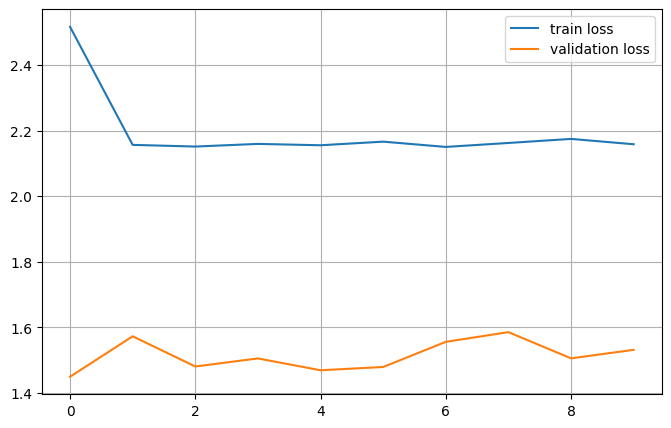

In [31]:
import matplotlib.pyplot as plt

epochs = list(range(0,10))

plt.figure(figsize=(8,5))
plt.plot(epochs,train_losses,label="train loss")
plt.plot(epochs,val_losses,label="validation loss")
plt.legend()
plt.grid()
plt.show()

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrics(y_test, y_pred):
    label = [1,2,3,4,5,6,7,8,9]
    
    C = confusion_matrix(y_test, y_pred)

    A = (((C.T) / C.sum(axis=1)).T)

    B = (C/C.sum(axis=0))

    print("-"*80, "Confusion Matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=label,yticklabels=label)
    plt.xlabel("Predicted Values")
    plt.ylabel("Original Values")
    plt.show()
    
    print("-"*80, "Precision Matrix (Column sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=label,yticklabels=label)
    plt.xlabel("Predicted Values")
    plt.ylabel("Original Values")
    plt.show()
    
    print("-"*80, "Recall Matrix (Column sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=label,yticklabels=label)
    plt.xlabel("Predicted Values")
    plt.ylabel("Original Values")
    plt.show()